## Ungraded Lab: Convolutional Autoencoders

In this lab, you will use convolution layers to build your autoencoder. This usually leads to better results than dense networks and you will see it in action with the [Fashion MNIST dataset](https://www.tensorflow.org/datasets/catalog/fashion_mnist).

## Imports

In [1]:
import tensorflow as tf
import tensorflow_datasets as tfds

import numpy as np
import matplotlib.pyplot as plt

2025-02-10 12:42:38.516815: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-02-10 12:42:38.526259: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1739187758.536594   22601 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1739187758.539842   22601 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-02-10 12:42:38.553857: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instr

## Prepare the Dataset

As before, you will load the train and test sets from TFDS. Notice that we don't flatten the image this time. That's because we will be using convolutional layers later that can deal with 2D images.

In [2]:
def map_image(image, label):
  '''Normalizes the image. Returns image as input and label.'''
  image = tf.cast(image, dtype=tf.float32)
  image = image / 255.0

  return image, image

In [3]:
BATCH_SIZE = 128
SHUFFLE_BUFFER_SIZE = 1024

train_dataset = tfds.load('fashion_mnist', as_supervised=True, split="train")
train_dataset = train_dataset.map(map_image)
train_dataset = train_dataset.shuffle(SHUFFLE_BUFFER_SIZE).batch(BATCH_SIZE).repeat()

test_dataset = tfds.load('fashion_mnist', as_supervised=True, split="test")
test_dataset = test_dataset.map(map_image)
test_dataset = test_dataset.batch(BATCH_SIZE).repeat()

2025-02-10 12:42:44.740583: W external/local_tsl/tsl/platform/cloud/google_auth_provider.cc:184] All attempts to get a Google authentication bearer token failed, returning an empty token. Retrieving token from files failed with "NOT_FOUND: Could not locate the credentials file.". Retrieving token from GCE failed with "FAILED_PRECONDITION: Error executing an HTTP request: libcurl code 6 meaning 'Couldn't resolve host name', error details: Could not resolve host: metadata.google.internal".


Dl Completed...: 0 url [00:00, ? url/s]
Dl Completed...:  25%|██▌       | 1/4 [00:00<00:00,  7.22 url/s]

Dl Completed...:  75%|███████▌  | 3/4 [00:00<00:00,  5.79 url/s]

Dl Completed...: 100%|██████████| 4/4 [00:01<00:00,  4.54 url/s]

Generating splits...:   0%|          | 0/2 [00:00<?, ? splits/s]I0000 00:00:1739187767.921390   22601 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 21770 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3090, pci bus id: 0000:01:00.0, compute capability: 8.6
                                                                        

Dataset fashion_mnist downloaded and prepared to /home/mcc/tensorflow_datasets/fashion_mnist/3.0.1. Subsequent calls will reuse this data.


## Define the Model

As mentioned, you will use convolutional layers to build the model. This is composed of three main parts: encoder, bottleneck, and decoder. You will follow the configuration shown in the image below.

<img src="https://drive.google.com/uc?export=view&id=15zh7bst9KKvciRdCvMAH7kXt3nNkABzO" width="75%" height="75%"/>

The encoder, just like in previous labs, will contract with each additional layer. The features are generated with the Conv2D layers while the max pooling layers reduce the dimensionality.

In [4]:
def encoder(inputs):
  '''Defines the encoder with two Conv2D and max pooling layers.'''
  conv_1 = tf.keras.layers.Conv2D(filters=64, kernel_size=(3,3), activation='relu', padding='same')(inputs)
  max_pool_1 = tf.keras.layers.MaxPooling2D(pool_size=(2,2))(conv_1)

  conv_2 = tf.keras.layers.Conv2D(filters=128, kernel_size=(3,3), activation='relu', padding='same')(max_pool_1)
  max_pool_2 = tf.keras.layers.MaxPooling2D(pool_size=(2,2))(conv_2)

  return max_pool_2

A bottleneck layer is used to get more features but without further reducing the dimension afterwards. Another layer is inserted here for visualizing the encoder output.

In [5]:
def bottle_neck(inputs):
  '''Defines the bottleneck.'''
  bottle_neck = tf.keras.layers.Conv2D(filters=256, kernel_size=(3,3), activation='relu', padding='same')(inputs)
  encoder_visualization = tf.keras.layers.Conv2D(filters=1, kernel_size=(3,3), activation='sigmoid', padding='same')(bottle_neck)

  return bottle_neck, encoder_visualization

The decoder will upsample the bottleneck output back to the original image size.

In [6]:
def decoder(inputs):
  '''Defines the decoder path to upsample back to the original image size.'''
  conv_1 = tf.keras.layers.Conv2D(filters=128, kernel_size=(3,3), activation='relu', padding='same')(inputs)
  up_sample_1 = tf.keras.layers.UpSampling2D(size=(2,2))(conv_1)

  conv_2 = tf.keras.layers.Conv2D(filters=64, kernel_size=(3,3), activation='relu', padding='same')(up_sample_1)
  up_sample_2 = tf.keras.layers.UpSampling2D(size=(2,2))(conv_2)

  conv_3 = tf.keras.layers.Conv2D(filters=1, kernel_size=(3,3), activation='sigmoid', padding='same')(up_sample_2)

  return conv_3

You can now build the full autoencoder using the functions above.

In [7]:
def convolutional_auto_encoder():
  '''Builds the entire autoencoder model.'''
  inputs = tf.keras.Input(shape=(28, 28, 1,))
  encoder_output = encoder(inputs)
  bottleneck_output, encoder_visualization = bottle_neck(encoder_output)
  decoder_output = decoder(bottleneck_output)

  model = tf.keras.Model(inputs =inputs, outputs=decoder_output)
  encoder_model = tf.keras.Model(inputs=inputs, outputs=encoder_visualization)
  return model, encoder_model


In [8]:
convolutional_model, convolutional_encoder_model = convolutional_auto_encoder()
convolutional_model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 28, 28, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 28, 28, 64)     │           640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 14, 14, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 14, 14, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 7, 7, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 7, 7, 256)      │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 7, 7, 128)      │       295,040 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling2d (UpSampling2D)    │ (None, 14, 14, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 14, 14, 64)     │        73,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling2d_1 (UpSampling2D)  │ (None, 28, 28, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 28, 28, 1)      │           577 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 739,073 (2.82 MB)

 Trainable params: 739,073 (2.82 MB)

 Non-trainable params: 0 (0.00 B)

## Compile and Train the model

In [9]:
train_steps = 60000 // BATCH_SIZE
valid_steps = 60000 // BATCH_SIZE

convolutional_model.compile(optimizer=tf.keras.optimizers.Adam(), loss='binary_crossentropy')
conv_model_history = convolutional_model.fit(train_dataset, steps_per_epoch=train_steps, validation_data=test_dataset, validation_steps=valid_steps, epochs=40)

Epoch 1/40


2025-02-10 12:43:34.589625: I tensorflow/core/kernels/data/tf_record_dataset_op.cc:376] The default buffer size is 262144, which is overridden by the user specified `buffer_size` of 8388608
I0000 00:00:1739187814.620695   22772 service.cc:148] XLA service 0x7f20a800e400 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1739187814.620818   22772 service.cc:156]   StreamExecutor device (0): NVIDIA GeForce RTX 3090, Compute Capability 8.6
2025-02-10 12:43:34.656427: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1739187814.799036   22772 cuda_dnn.cc:529] Loaded cuDNN version 90300


 30/468 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.5272

I0000 00:00:1739187816.808918   22772 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


468/468 ━━━━━━━━━━━━━━━━━━━━ 8s 10ms/step - loss: 0.3295 - val_loss: 0.2659
Epoch 2/40
468/468 ━━━━━━━━━━━━━━━━━━━━ 5s 8ms/step - loss: 0.2615 - val_loss: 0.2590
Epoch 3/40
468/468 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - loss: 0.2562 - val_loss: 0.2556
Epoch 4/40
468/468 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - loss: 0.2529 - val_loss: 0.2540
Epoch 5/40
468/468 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - loss: 0.2512 - val_loss: 0.2548
Epoch 6/40
468/468 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - loss: 0.2505 - val_loss: 0.2522
Epoch 7/40
468/468 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - loss: 0.2496 - val_loss: 0.2513
Epoch 8/40
468/468 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - loss: 0.2491 - val_loss: 0.2510
Epoch 9/40
468/468 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - loss: 0.2482 - val_loss: 0.2514
Epoch 10/40
468/468 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - loss: 0.2484 - val_loss: 0.2499
Epoch 11/40
468/468 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - loss: 0.2478 - val_loss: 0.2495
Epoch 12/40
468/468 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - loss: 0

## Display sample results

As usual, let's see some sample results from the trained model.

In [10]:
def display_one_row(disp_images, offset, shape=(28, 28)):
  '''Display sample outputs in one row.'''
  for idx, test_image in enumerate(disp_images):
    plt.subplot(3, 10, offset + idx + 1)
    plt.xticks([])
    plt.yticks([])
    test_image = np.reshape(test_image, shape)
    plt.imshow(test_image, cmap='gray')


def display_results(disp_input_images, disp_encoded, disp_predicted, enc_shape=(8,4)):
  '''Displays the input, encoded, and decoded output values.'''
  plt.figure(figsize=(15, 5))
  display_one_row(disp_input_images, 0, shape=(28,28,))
  display_one_row(disp_encoded, 10, shape=enc_shape)
  display_one_row(disp_predicted, 20, shape=(28,28,))

2025-02-10 12:46:04.373088: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 227ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 278ms/step


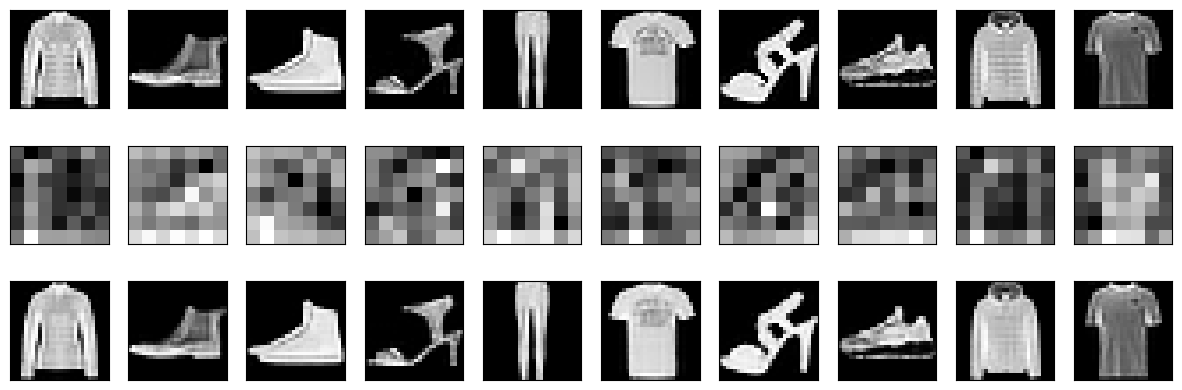

In [11]:
# take 1 batch of the dataset
test_dataset = test_dataset.take(1)

# take the input images and put them in a list
output_samples = []
for input_image, image in tfds.as_numpy(test_dataset):
      output_samples = input_image

# pick 10 indices
idxs = np.array([1, 2, 3, 4, 5, 6, 7, 8, 9, 10])

# prepare test samples as a batch of 10 images
conv_output_samples = np.array(output_samples[idxs])
conv_output_samples = np.reshape(conv_output_samples, (10, 28, 28, 1))

# get the encoder ouput
encoded = convolutional_encoder_model.predict(conv_output_samples)

# get a prediction for some values in the dataset
predicted = convolutional_model.predict(conv_output_samples)

# display the samples, encodings and decoded values!
display_results(conv_output_samples, encoded, predicted, enc_shape=(7,7))